In [ ]:
pip install catboost

In [ ]:
pip install optuna

In [ ]:
import math
import pickle
import random
from typing import List, Tuple

import numpy as np
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [ ]:
import torch

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import optuna
import joblib

In [ ]:
class LambdaMART_10k():
    def __init__(self, n_estimators: int = 100, lr: float = 0.5, ndcg_top_k: int = 10,
                 subsample: float = 0.6, colsample_bytree: float = 0.9,
                 max_depth: int = 5, min_samples_leaf: int = 8):
        self._prepare_data()

        self.ndcg_top_k = ndcg_top_k
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

        self.subsample = subsample
        self.colsample_bytree = colsample_bytree

    def _get_data(self) -> List[np.ndarray]:
        train_df, test_df = msrank_10k()

        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[0].values
        query_ids_train = train_df[1].values.astype(int)

        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[0].values
        query_ids_test = test_df[1].values.astype(int)

        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()

        self.X_train = torch.FloatTensor(self._scale_features_in_query_groups(X_train, self.query_ids_train))
        self.y_train = torch.FloatTensor(y_train).reshape(-1, 1)

        self.X_test = torch.FloatTensor(self._scale_features_in_query_groups(X_test, self.query_ids_test))
        self.y_test = torch.FloatTensor(y_test).reshape(-1, 1)


    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray,
                                        inp_query_ids: np.ndarray) -> np.ndarray:
        query_idx = {query: [] for query in np.unique(inp_query_ids)}
        scaler = StandardScaler()
        for idx, query in enumerate(inp_query_ids, 0):
            query_idx[query].append(idx)
        for query in query_idx:
            inp_feat_array[query_idx[query]] = scaler.fit_transform(inp_feat_array[query_idx[query]])
        return inp_feat_array

    def _train_one_tree(self, cur_tree_idx: int,
                        train_preds: torch.FloatTensor
                        ) -> Tuple[DecisionTreeRegressor, np.ndarray]:
        np.random.seed(cur_tree_idx)

        tree = DecisionTreeRegressor(max_depth = self.max_depth,
                                     min_samples_leaf = self.min_samples_leaf,
                                     random_state = cur_tree_idx)

        X_rows_index = range(self.X_train.shape[0])
        X_cols_index = range(self.X_train.shape[1])
        rows_n = int(self.subsample*self.X_train.shape[0])
        cols_n = int(self.colsample_bytree*self.X_train.shape[1])

        X_tree_rows = torch.IntTensor(np.random.choice(X_rows_index, rows_n, replace = False).tolist())
        X_tree_cols = torch.IntTensor(np.random.choice(X_cols_index, cols_n, replace = False).tolist())

        X_tree_fit = torch.index_select(torch.index_select(self.X_train, 1, X_tree_cols),
                                0, X_tree_rows)
        y_preds_tree = torch.index_select(self.y_train, 0, X_tree_rows)
        train_preds_tree = torch.index_select(train_preds, 0, X_tree_rows)

        queries_tree = self.query_ids_train[X_tree_rows]

        query_idx = {query: [] for query in np.unique(queries_tree)}
        for idx, query in enumerate(queries_tree, 0):
            query_idx[query].append(idx)

        l = torch.zeros(X_tree_fit.shape[0])

        for query, idx in query_idx.items():
            rows_idx = torch.IntTensor(idx)
            y_query = torch.index_select(y_preds_tree, 0, rows_idx)
            y_preds = torch.index_select(train_preds_tree, 0, rows_idx)
            l_q = self._compute_lambdas(y_query, y_preds)
            l_q = l_q.sum(dim = 1)
            for row, l_q_v in zip(rows_idx, l_q):
                l[row.item()] = l_q_v.item()

        tree.fit(X_tree_fit.numpy(), -l.numpy())
        return tree, X_tree_cols

    def _calc_data_ndcg(self, queries_list: np.ndarray,
                        true_labels: torch.FloatTensor, preds: torch.FloatTensor) -> float:
        ndcgs = []
        query_idx = {query: [] for query in np.unique(queries_list)}
        scaler = StandardScaler()
        for idx, query in enumerate(queries_list, 0):
            query_idx[query].append(idx)
        for query in query_idx:
            ndcg = self._ndcg_k(true_labels[query_idx[query]], preds[query_idx[query]], self.ndcg_top_k)
            if np.isnan(ndcg):
                ndcg = 0
            ndcgs.append(ndcg)
        return np.mean(ndcgs)

    def fit(self, print_training = None):
        np.random.seed(0)

        train_preds = torch.zeros(self.y_train.shape)
        train_ndcgs = []

        train_list = []

        test_preds = torch.zeros(self.y_test.shape)
        test_ndcgs = []

        self.cols_list = []
        self.trees = []
        self.preds_list = []

        for i in range(self.n_estimators):
            tree, cols = self._train_one_tree(i, train_preds)
            self.trees.append(tree)
            self.cols_list.append(cols)

            train_list.append(train_preds)

            train_preds += self.lr*torch.FloatTensor(tree.predict(torch.index_select(self.X_train, 1, cols).numpy())).reshape(-1, 1)
            train_score = self._calc_data_ndcg(self.query_ids_train, self.y_train, train_preds)
            train_ndcgs.append(train_score)

            test_preds += torch.FloatTensor(tree.predict(torch.index_select(self.X_test, 1, cols).numpy())).reshape(-1, 1)
            test_score = self._calc_data_ndcg(self.query_ids_test, self.y_test, test_preds)
            test_ndcgs.append(test_score)

            if print_training:
                print(f'Tree {i} ndcg@{self.ndcg_top_k}: train = {train_score}, test = {test_score}')
        if print_training:
            plt.plot(range(self.n_estimators), train_ndcgs)
            plt.plot(range(self.n_estimators), test_ndcgs)
            plt.legend(['train_ndcg', 'test_ndcg'])

        max_ndcg_idx = test_ndcgs.index(max(test_ndcgs))
        self.best_ndcg = test_ndcgs[max_ndcg_idx]
        self.trees = self.trees[:max_ndcg_idx+1]
        self.cols_list = self.cols_list[:max_ndcg_idx+1]
        return self.best_ndcg

    def predict(self, data: torch.FloatTensor) -> torch.FloatTensor:
        preds = torch.zeros(data.shape[0], 1)

        for tree, cols in zip(self.trees, self.cols_list):
            tree_preds = torch.FloatTensor(tree.predict(torch.index_select(data, 1, cols).numpy())).reshape(-1, 1)
            preds += self.lr*tree_preds
        return preds

    def _compute_lambdas(self, y_true: torch.FloatTensor, y_pred: torch.FloatTensor) -> torch.FloatTensor:
        # dnDCG = (1/ideal_dcg)*(gain_diff)*(logs_diff)

        ideal_dcg = self._ideal_dcg(y_true)
        N = 1/ideal_dcg
        if np.isnan(N) or ideal_dcg == 0:
            N = 0
        _, rank_order = torch.sort(y_true, descending=True, axis=0)
        rank_order += 1

        gain_diff = torch.pow(2, y_true)-torch.pow(2, y_true.t())

        decay_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))\

        dnDCG = torch.abs(N * gain_diff * decay_diff)

        pos_pairs_score_diff = 1.0 + torch.exp((y_pred - y_pred.t()))
        # Sij
        scores_diff = y_true-y_true.t()
        pos_pairs = (scores_diff>0).type(torch.int32)
        neg_pairs = (scores_diff<0).type(torch.int32)
        Sij = pos_pairs - neg_pairs

        # (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff)*dnDCG
        return (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff)*dnDCG

    def _ndcg_k(self, ys_true, ys_pred, ndcg_top_k) -> float:
        def dcg(ys_true, ys_pred):
            _, argsort = torch.sort(ys_pred, descending=True, dim=0)
            argsort = argsort[:ndcg_top_k]
            ys_true_sorted = ys_true[argsort]
            gain = 0
            for i, l in enumerate(ys_true_sorted, 1):
                gain += (2 ** l - 1) / math.log2(1 + i)
            return gain
        ideal_dcg = dcg(ys_true, ys_true)
        pred_dcg = dcg(ys_true, ys_pred)
        return (pred_dcg / ideal_dcg).item()

    def _ideal_dcg(self, ys_true) -> float:
        def dcg(ys_true, ys_pred):
            _, argsort = torch.sort(ys_pred, descending=True, dim=0)
            ys_true_sorted = ys_true[argsort]
            gain = 0
            for i, l in enumerate(ys_true_sorted, 1):
                gain += (2 ** l - 1) / math.log2(1 + i)
            return gain
        return dcg(ys_true, ys_true)
    def save_model(self, path: str):
        state = {
            'trees': self.trees,
            'trees_feat_idxs': self.trees_feat_idxs,
            'lr': self.lr
        }
        f = open(path, 'wb')
        pickle.dump(state, f)

    def load_model(self, path: str):
        f = open(path, 'rb')
        state = pickle.load(f)
        self.trees = state['trees']
        self.trees_feat_idxs = state['trees_feat_idxs']
        self.lr = state['lr']

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    lr = trial.suggest_float("lr", 1e-4, 1)
    subsample = trial.suggest_float("subsample", 0.0, 0.9999)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.0, 136/137)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 20)
    ndcg_top_k = 10
    score = LambdaMART_10k(n_estimators, lr, ndcg_top_k, subsample, colsample_bytree, max_depth, min_samples_leaf).fit()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-08-01 16:15:49,903] A new study created in memory with name: no-name-d333399e-f17a-4c93-8cd3-f2904db68db4
[I 2023-08-01 16:20:32,790] Trial 0 finished with value: 0.4306043646806343 and parameters: {'n_estimators': 186, 'lr': 0.6045199074684007, 'subsample': 0.9773745795569279, 'colsample_bytree': 0.908677330739053, 'max_depth': 7, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.4306043646806343.
[I 2023-08-01 16:21:55,437] Trial 1 finished with value: 0.3607463827780025 and parameters: {'n_estimators': 111, 'lr': 0.6663037713170612, 'subsample': 0.7083072087904595, 'colsample_bytree': 0.1929234375469661, 'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.4306043646806343.
[I 2023-08-01 16:23:20,105] Trial 2 finished with value: 0.3852276294280521 and parameters: {'n_estimators': 131, 'lr': 0.36647657926317023, 'subsample': 0.684837223904673, 'colsample_bytree': 0.0949696875527069, 'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.

KeyboardInterrupt: ignored

In [ ]:
LamdaMART = LambdaMART_10k(**{'n_estimators': 175,
                         'lr': 0.6196291225251893, 'subsample': 0.918126554572848,
                         'colsample_bytree': 0.9059311624006442, 'max_depth': 9,
                         'min_samples_leaf': 19})

Tree 0 ndcg@10: train = 0.5171892120577823, test = 0.3611031253398819
Tree 1 ndcg@10: train = 0.583675035114946, test = 0.37856525739400904
Tree 2 ndcg@10: train = 0.5953003118435541, test = 0.3900551534977488
Tree 3 ndcg@10: train = 0.6175771463533928, test = 0.3989223285197196
Tree 4 ndcg@10: train = 0.6345514850369816, test = 0.40670586967925454
Tree 5 ndcg@10: train = 0.6516942923096405, test = 0.4032273869749836
Tree 6 ndcg@10: train = 0.6619218892749699, test = 0.4136299703227864
Tree 7 ndcg@10: train = 0.6736072596462294, test = 0.4077527990818701
Tree 8 ndcg@10: train = 0.6768882798737493, test = 0.4009376762180843
Tree 9 ndcg@10: train = 0.6803962834950151, test = 0.39886727471920574
Tree 10 ndcg@10: train = 0.6851207206304046, test = 0.4018547725863755
Tree 11 ndcg@10: train = 0.6813608205866539, test = 0.4033362406983294
Tree 12 ndcg@10: train = 0.6981307069460551, test = 0.4066471269946884
Tree 13 ndcg@10: train = 0.7060119314440365, test = 0.40756974017924885
Tree 14 ndcg@

0.4324944074773653

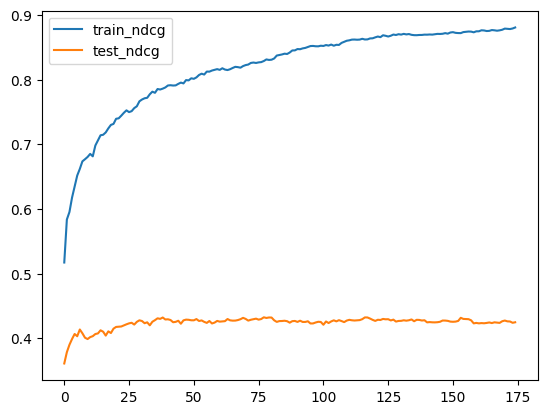

In [ ]:
LamdaMART.fit(print_training='print')